# Callbacks
모델을 훈련시키는 일은 대체적으로 오랜 시간이 걸린다. Tensorflow가 기본적인 Log를 출력해주기는 하지만 훈련이 끝날 때까지 기도하고 있기에는 불안한 일이므로 tensorflow는 모델을 훈련시키는 동안 어떤 이벤트들이 발생하면 개발자가 원하는 동작을 수행할 수 있는 방법을 제공한다. 이때, 개발자가 원하는 동작을 Callback이라고 부른다.

In [3]:
import os
from glob import glob
from datetime import datetime

import numpy as np
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext tensorboard

## Hyperparameter Tunning

In [2]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('../dataset/cifar/train/*.png')[:5000]  
test_paths = glob('../dataset/cifar/test/*.png')[:1000]

len(train_paths), len(test_paths)

(5000, 1000)

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

# Callbacks

In [14]:
logdir = os.path.join("logs_basic", datetime.now().strftime("%Y%m%d-%H%M%S"))
logdir

'logs_basic\\20210722-225341'

In [15]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    write_graph = True,
    write_images = True,
    histogram_freq = 1
)

### LambdaCallback

In [16]:
import sklearn.metrics
import itertools
import io

file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [17]:
test_images, test_labels = next(iter(test_dataset))  # Confusion Matrix 그릴 때 필요한 Test Image


def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [18]:
# Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## Training

In [19]:
'''
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[tensorboard]
)
'''

'\nsteps_per_epoch = len(train_paths) // batch_size\nvalidation_steps = len(test_paths) // batch_size\n\nmodel.fit_generator(\n    train_dataset,\n    steps_per_epoch=steps_per_epoch,\n    validation_data=test_dataset,\n    validation_steps=validation_steps,\n    epochs=num_epochs,\n    callbacks=[tensorboard]\n)\n'

In [20]:
%tensorboard --logdir logs_basic --port 2222

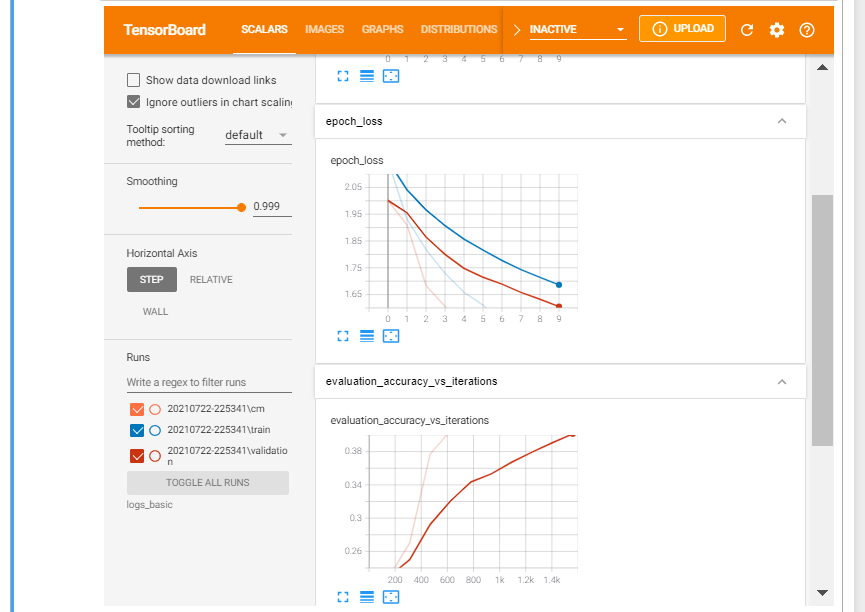

In [6]:
Image("G:/내 드라이브/패스트캠퍼스/Part3)/1.PNG")

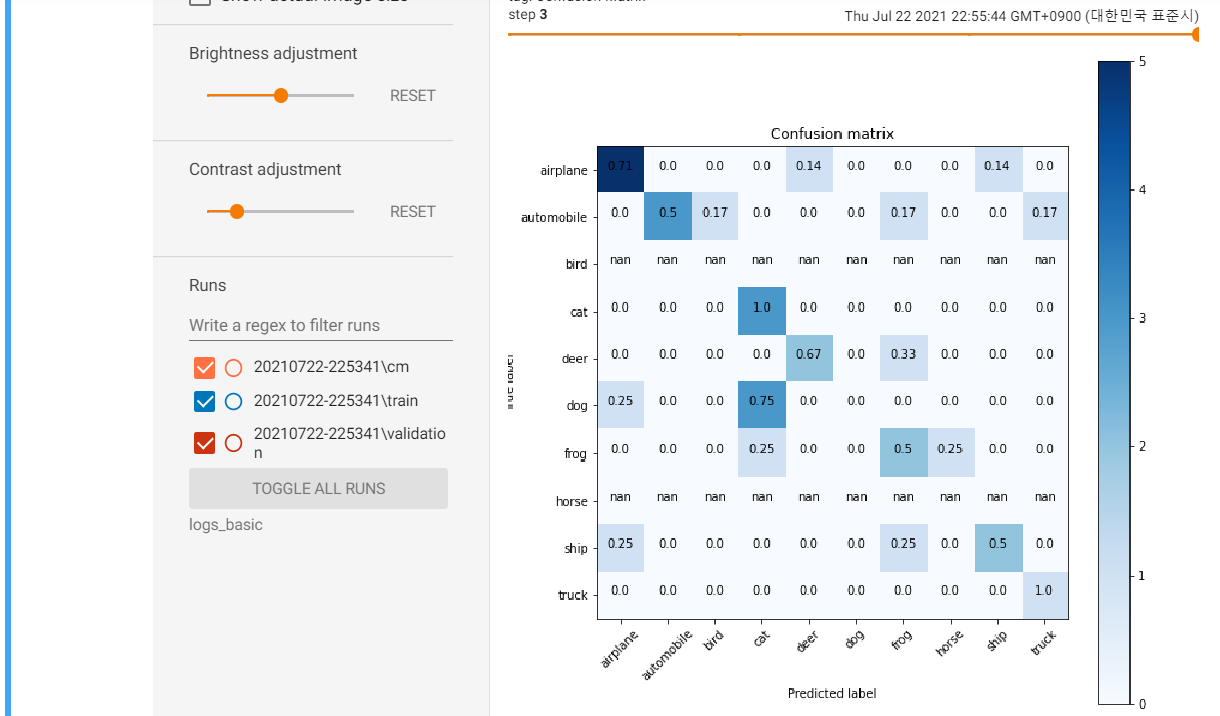

In [7]:
Image("G:/내 드라이브/패스트캠퍼스/Part3)/2.PNG")

### confustion matrix까지 보여주는 training

In [21]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[tensorboard, cm_callback]
)

C:\Users\jumin\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
156/156 [==============================] - 33s 161ms/step - loss: 2.1497 - accuracy: 0.1771 - val_loss: 2.0011 - val_accuracy: 0.2298


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 2/10
156/156 [==============================] - 26s 165ms/step - loss: 1.9316 - accuracy: 0.2613 - val_loss: 1.9100 - val_accuracy: 0.2702


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 3/10
156/156 [==============================] - 23s 146ms/step - loss: 1.8177 - accuracy: 0.3182 - val_loss: 1.6843 - val_accuracy: 0.3770


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 4/10
156/156 [==============================] - 22s 143ms/step - loss: 1.7301 - accuracy: 0.3430 - val_loss: 1.6069 - val_accuracy: 0.4052


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 5/10
156/156 [==============================] - 24s 153ms/step - loss: 1.6588 - accuracy: 0.3804 - val_loss: 1.5369 - val_accuracy: 0.4345


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 6/10
156/156 [==============================] - 24s 153ms/step - loss: 1.6107 - accuracy: 0.4016 - val_loss: 1.5516 - val_accuracy: 0.4022


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 7/10
156/156 [==============================] - 25s 158ms/step - loss: 1.5458 - accuracy: 0.4259 - val_loss: 1.5355 - val_accuracy: 0.4506


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 8/10
156/156 [==============================] - 22s 143ms/step - loss: 1.5035 - accuracy: 0.4434 - val_loss: 1.4449 - val_accuracy: 0.4637


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 9/10
156/156 [==============================] - 22s 144ms/step - loss: 1.4835 - accuracy: 0.4547 - val_loss: 1.4287 - val_accuracy: 0.4808


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


Epoch 10/10
156/156 [==============================] - 24s 154ms/step - loss: 1.4385 - accuracy: 0.4752 - val_loss: 1.3578 - val_accuracy: 0.4980


<ipython-input-16-7b96622c03d1>:41: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


## 새로운 창에서 Tensorboard 보고싶을 때

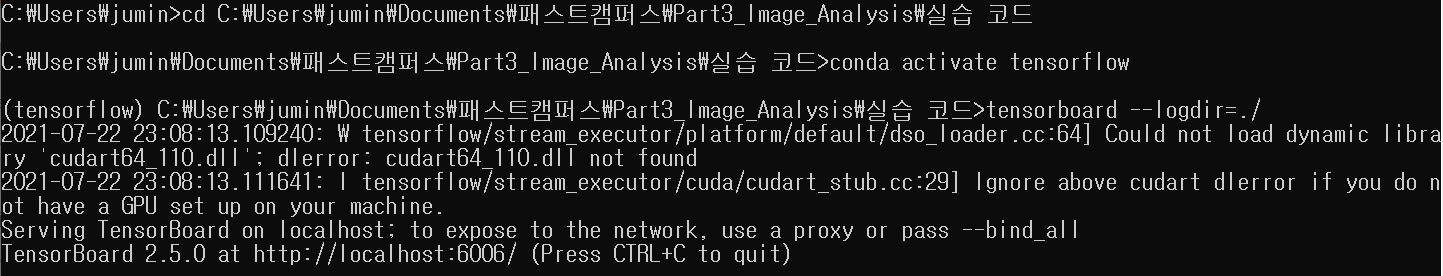

In [8]:
Image("G:/내 드라이브/패스트캠퍼스/Part3)/3.PNG")